# Initial setup to clear compatibility issues between numpy and pdmarima

In [ ]:
pip install --upgrade pip setuptools wheel

In [8]:
%pip install numpy==1.26.4 --no-build-isolation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 76.2 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install setuptools==59.1.0 --no-build-isolation

Reason for being yanked: https://github.com/pypa/setuptools/issues/2885
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 951.2/951.2 kB 42.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 60.0.0
    Uninstalling setuptools-60.0.0:
      Successfully uninstalled setuptools-60.0.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pmdarima 2.0.4 requires numpy>=1.21.2, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install pmdarima

In [ ]:
%pip install statsmodels

 # 1. Import necessary libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

## Get Stock price details from Yahoo finance

In [3]:
sharesList = ['JPM', 'BATAINDIA.NS']
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2025, 4, 1)

In [4]:
df_complete = yf.download(sharesList, start= start, end= end, progress=False)

YF.download() has changed argument auto_adjust default to True


In [5]:
df_complete.Close.head()

Ticker,BATAINDIA.NS,JPM
Date,,
2020-01-01,1684.222168,NaN
2020-01-02,1689.722656,120.733551
2020-01-03,1679.203979,119.140305
2020-01-06,1644.898193,119.045578
2020-01-07,1656.237183,117.021736


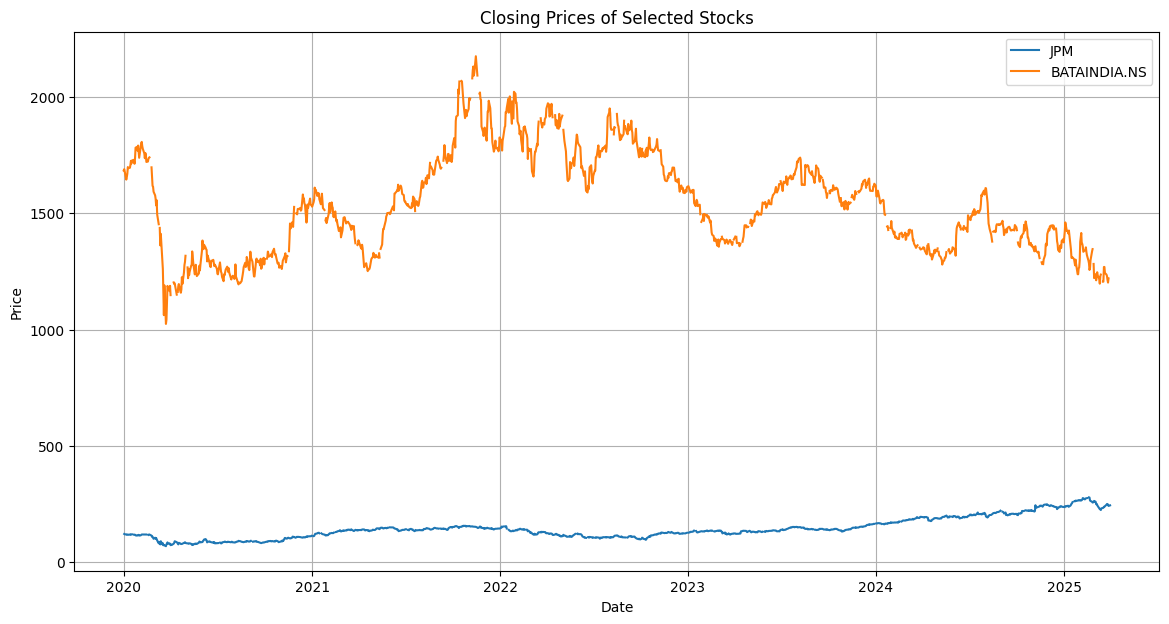

In [6]:
# Plot the closing prices
plt.figure(figsize=(14, 7))
for share in sharesList:
    plt.plot(df_complete['Close'][share], label=share)
plt.title('Closing Prices of Selected Stocks')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## Handle missing data for missing days

In [7]:
# Find out the missing business days in df_complete
df_complete.Close.asfreq('d').isna().sum()

Ticker
BATAINDIA.NS    617
JPM             599
dtype: int64

In [8]:
# Add the missing days
df_complete = df_complete.asfreq('d')
df_complete_alldays = df_complete.asfreq('d')

In [9]:
df_complete_alldays.head()

Price             Close                     High                      Low  \
Ticker     BATAINDIA.NS         JPM BATAINDIA.NS         JPM BATAINDIA.NS   
Date                                                                        
2020-01-01  1684.222168         NaN  1702.943158         NaN  1682.485113   
2020-01-02  1689.722656  120.733551  1697.490989  120.742117  1671.580527   
2020-01-03  1679.203979  119.140305  1695.753827  119.906784  1669.602234   
2020-01-04          NaN         NaN          NaN         NaN          NaN   
2020-01-05          NaN         NaN          NaN         NaN          NaN   

Price                          Open                   Volume              
Ticker             JPM BATAINDIA.NS         JPM BATAINDIA.NS         JPM  
Date                                                                      
2020-01-01         NaN  1690.253445         NaN     214199.0         NaN  
2020-01-02  119.167582  1686.827643  119.621112     269100.0  10803700.0  
2020-01-03  118.055180  1689.819027  118.416888     233227.0  10386800.0  
2020-01-04         NaN          NaN         NaN          NaN         NaN  
2020-01-05         NaN          NaN         NaN          NaN         NaN

# 2. EDA

## 2.1 Trend Analysis

In [10]:
# Create a function to plot Close prices of a selected stock
def plot_stock_prices(stock_symbol):
    plt.figure(figsize=(14, 7))
    plt.plot(df_complete_alldays['Close'][stock_symbol], label=stock_symbol)
    plt.title(f'Closing Prices of {stock_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

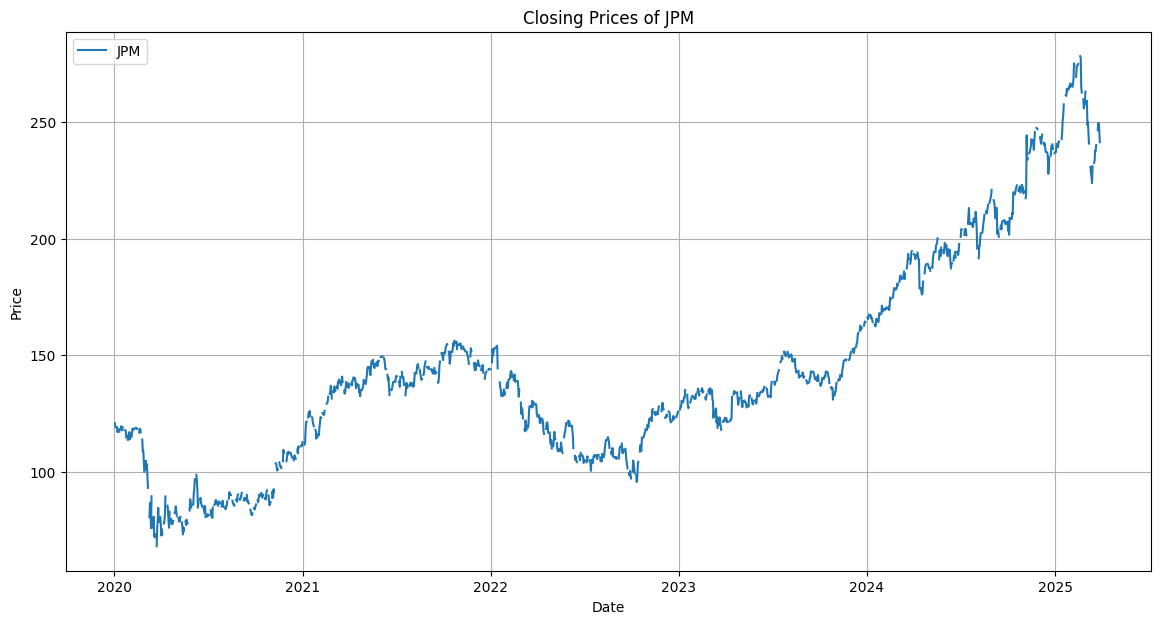

In [11]:
# Plot stocl price of JPM
plot_stock_prices('JPM')

## 2.2 Interpolate missing values

In [12]:
# Interpolate the missing values
df_complete_alldays['Close'] = df_complete_alldays['Close'].interpolate(method='linear')


In [13]:
df_complete_alldays['Close'].isna().sum()

Ticker
BATAINDIA.NS    0
JPM             1
dtype: int64

In [14]:
# Print the date when JPM close price was NaN
df_complete_alldays[df_complete_alldays['Close']=='NaN'].index[0]

Timestamp('2020-01-01 00:00:00')

In [15]:
# drop first row
df_complete_alldays.drop(df_complete_alldays.index[0], inplace=True)

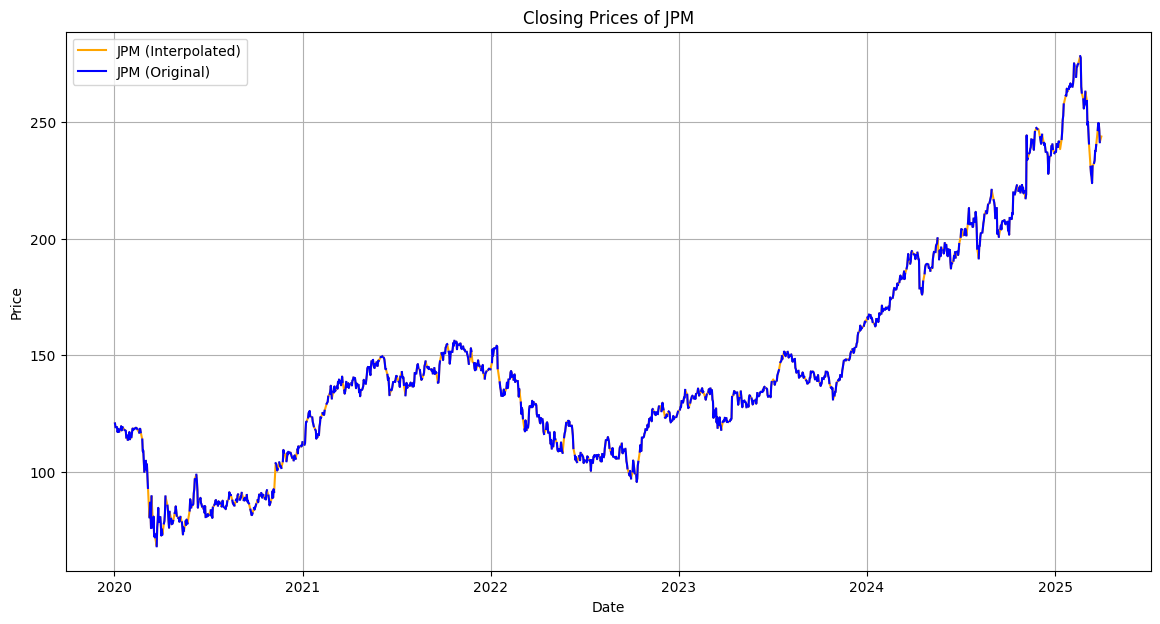

In [16]:
# Plot Close price for JPM from df_complete_alldays and df_complete
plt.figure(figsize=(14, 7))

plt.plot(df_complete_alldays['Close']['JPM'], label='JPM (Interpolated)', color='orange')
plt.plot(df_complete['Close']['JPM'], label='JPM (Original)', color='blue')

plt.title('Closing Prices of JPM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## 2.3 Seasonality check

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [18]:
# Decompose the time series
def decompose_stock_prices(stock_symbol):
    stock_data = df_complete_alldays['Close'][stock_symbol]
    decomposition = seasonal_decompose(stock_data, model='multiplicative', period=21)
    
    plt.figure(figsize=(14, 10))
    decomposition.plot()
    plt.suptitle(f'Seasonal Decomposition of {stock_symbol}', fontsize=16)
    plt.show()
    return decomposition

<Figure size 1400x1000 with 0 Axes>

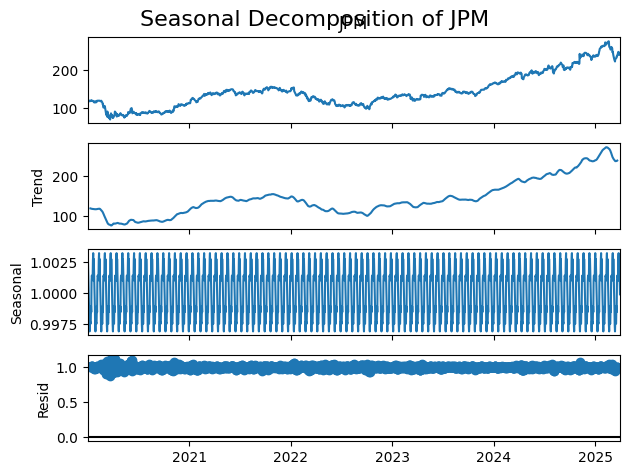

In [19]:
# Decompose stock price of JPM
decomposition = decompose_stock_prices('JPM')

In [20]:
# Split the decomposed data into trend, seasonal, and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

## 2.4 Residual Analysis

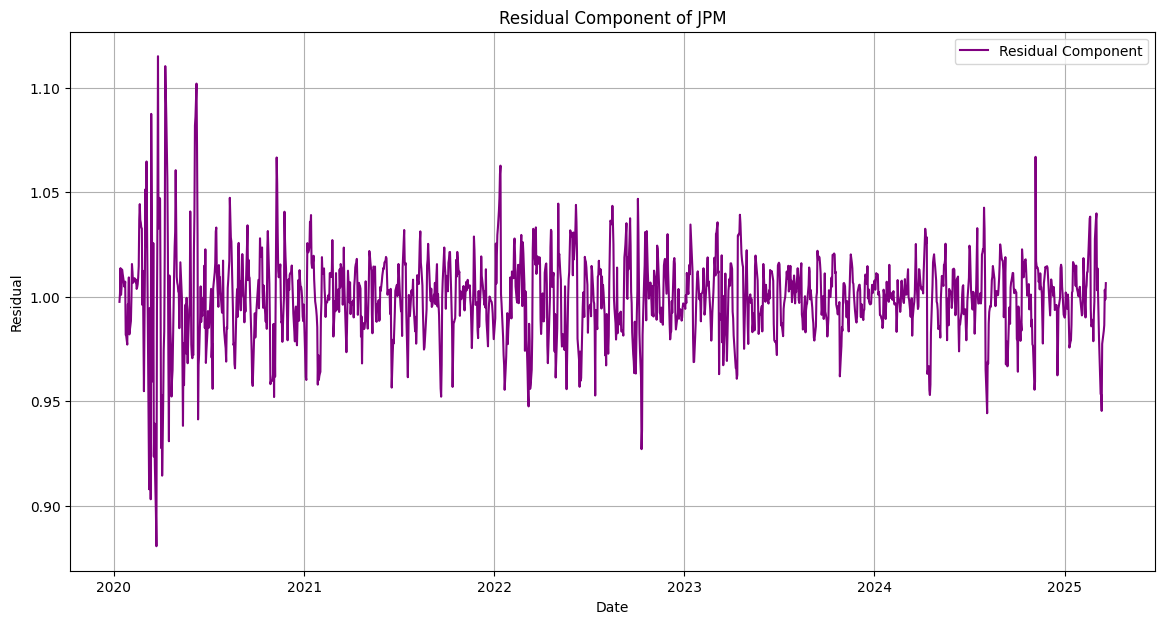

In [21]:
# Plot last 100 days of residual component
plt.figure(figsize=(14, 7))
plt.plot(residual, label='Residual Component', color='purple')
plt.title('Residual Component of JPM')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.grid()
plt.show()

# 3. Stationarity Check

In [22]:
# ADF test for stationarity
def adf_test(stock_symbol):
    stock_data = df_complete_alldays['Close'][stock_symbol].dropna()
    result = adfuller(stock_data)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] <= 0.05:
        print(f'The time series {stock_symbol} is stationary.')
    else:
        print(f'The time series {stock_symbol} is non-stationary.')

In [23]:
# ADF test for JPM
adf_test('JPM')

ADF Statistic: 0.006655126669397911
p-value: 0.9590790120736565
Critical Values:
   1%: -3.4337855345177255
   5%: -2.863057593089076
   10%: -2.56757790858712
The time series JPM is non-stationary.


In [24]:
residual.dropna(inplace=True)

In [25]:
# ADF test on residual component
result = adfuller(residual)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')
if result[1] <= 0.05:
    print(f'The time series redsidual is stationary.')
else:
    print(f'The time series redsidual is non-stationary.')

ADF Statistic: -12.848904045695152
p-value: 5.4054222735864344e-24
Critical Values:
   1%: -3.433849890092939
   5%: -2.863086004488984
   10%: -2.567593036523882
The time series redsidual is stationary.


# ARIMA Model for Forecasting

In [26]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

## Split data set into test and train
Test data set for 14 days will be used to test one-step prediction

In [43]:
# Split data into train and test sets
test_size = 90 # 90 days
train_data = df_complete_alldays['Close']['JPM'][:-test_size]
test_data = df_complete_alldays['Close']['JPM'][-test_size:]
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [44]:
train_data.head(10)

Date
2020-01-02    120.733551
2020-01-03    119.140305
2020-01-04    119.108729
2020-01-05    119.077154
2020-01-06    119.045578
2020-01-07    117.021736
2020-01-08    117.934631
2020-01-09    118.365219
2020-01-10    117.185356
2020-01-11    117.509745
Freq: D, Name: JPM, dtype: float64

## Verify Autocorrelation (ACF) to identify seasonality if any

<Figure size 1400x700 with 0 Axes>

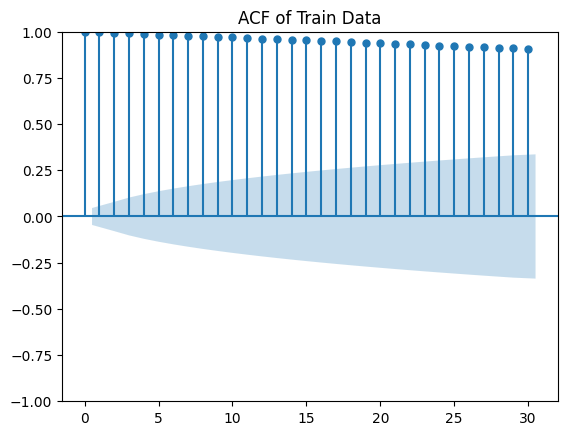

<Figure size 1400x700 with 0 Axes>

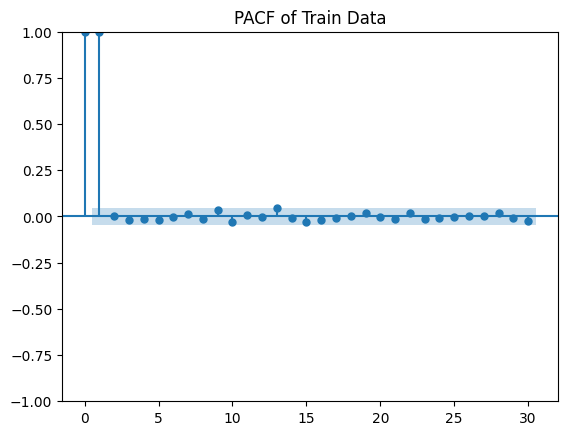

In [45]:
# Check ACF and PACF plots
plt.figure(figsize=(14, 7))
plot_acf(train_data, lags=30)
plt.title('ACF of Train Data')
plt.show()
plt.figure(figsize=(14, 7))
plot_pacf(train_data, lags=30)
plt.title('PACF of Train Data')
plt.show()

The data doesn’t exhibit autocorrelation, meaning past values don’t significantly impact future values, neither ARIMA nor SARIMA would be the most optimal choice for forecasting.

In [46]:
# import ndiff from pmdarima
from pmdarima.arima.utils import ndiffs
# Calculate the number of differences needed to make the series stationary
d = ndiffs(train_data)
print(f'Number of differences needed to make the series stationary: {d}')

Number of differences needed to make the series stationary: 1


<Figure size 1400x700 with 0 Axes>

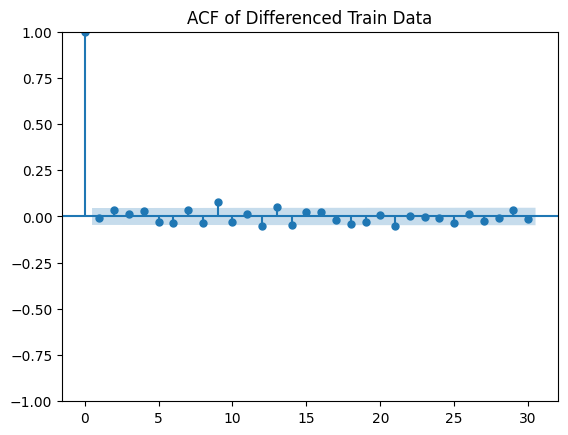

In [47]:
# Make the series stationary
train_data_diff = train_data.diff().dropna()
train_data_diff.head(10)
# Check ACF and PACF plots of differenced data
plt.figure(figsize=(14, 7))
plot_acf(train_data_diff, lags=30)
plt.title('ACF of Differenced Train Data')
plt.show()

q is the order of MA (Moving average term). It refers to the number of lagged forecasted errors that should go into ARIMA model. Based on ACF plot for the number of MA terms.

<Figure size 1400x700 with 0 Axes>

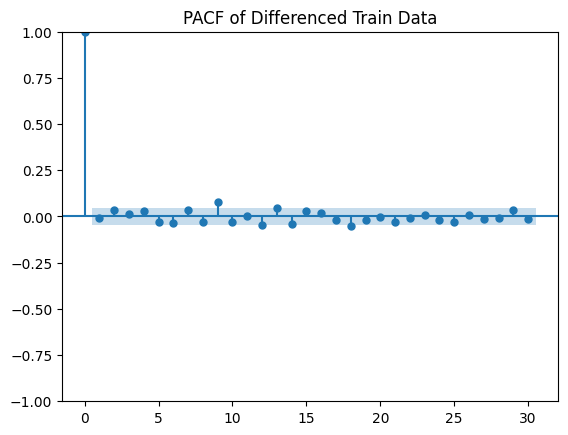

In [48]:
# Check PACF plots of differenced data
plt.figure(figsize=(14, 7))
plot_pacf(train_data_diff, lags=30)
plt.title('PACF of Differenced Train Data')
plt.show()

We can see that the PACF lag (p = 9) is above the significance level.

ARIMA parameters
p = 9
d = 1
q = 2

## ARIMA Model

In [62]:
# Create ARIMA model
p = 9 # from PACF plot
q = 9 # from ACF plot
d = 1 # from ndiffs
# Fit ARIMA model
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())
# Forecasting

                               SARIMAX Results                                
Dep. Variable:                    JPM   No. Observations:                 1826
Model:                 ARIMA(9, 1, 9)   Log Likelihood               -3703.238
Date:                Sun, 20 Apr 2025   AIC                           7444.475
Time:                        21:19:13   BIC                           7549.152
Sample:                    01-02-2020   HQIC                          7483.089
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4856      0.778     -0.624      0.533      -2.011       1.039
ar.L2         -0.2080      0.752     -0.277      0.782      -1.681       1.265
ar.L3         -0.0680      0.246     -0.276      0.7

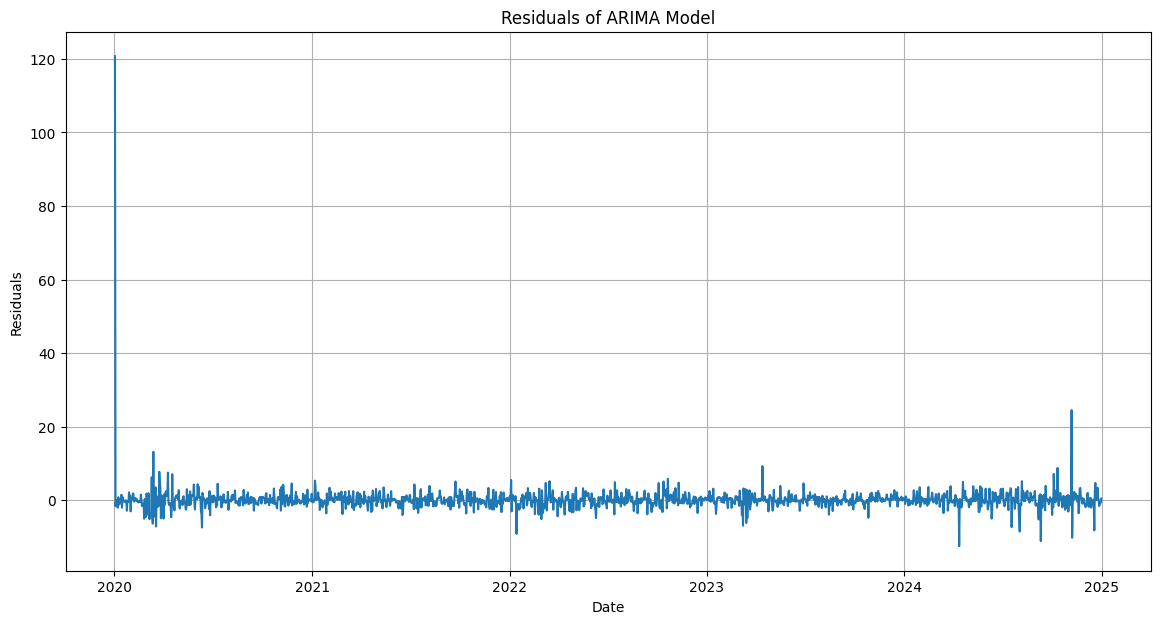

In [63]:
# Plot residuals
residuals = model_fit.resid
plt.figure(figsize=(14, 7))
plt.plot(residuals) 
plt.title('Residuals of ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid()
plt.show()

# Forecasting using ARIMA model

In [64]:
# Forecast the next 90 days
forecast = model_fit.forecast(steps=test_size)


In [65]:
forecast

2025-01-01    236.953657
2025-01-02    237.204391
2025-01-03    237.112830
2025-01-04    237.567855
2025-01-05    237.380926
                 ...    
2025-03-27    240.865312
2025-03-28    240.897512
2025-03-29    240.925892
2025-03-30    240.962721
2025-03-31    240.995867
Freq: D, Name: predicted_mean, Length: 90, dtype: float64

In [66]:
forecast = pd.Series(forecast, index=test_data.index)

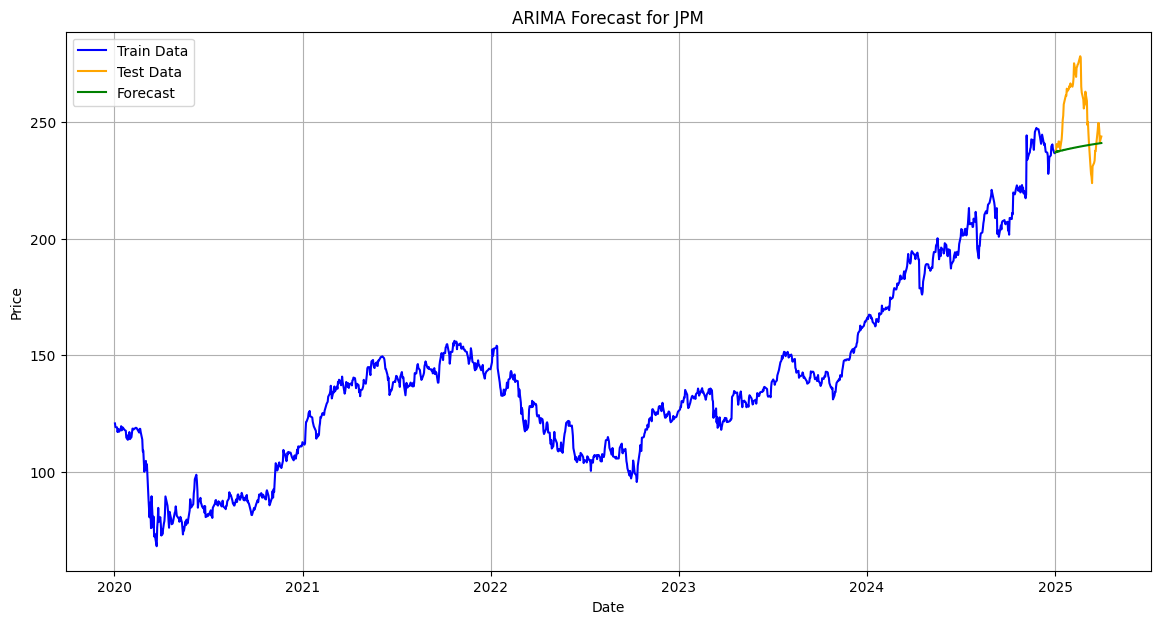

In [67]:
# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Train Data', color='blue')
plt.plot(test_data, label='Test Data', color='orange')
plt.plot(forecast, label='Forecast', color='green')
plt.title('ARIMA Forecast for JPM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

#  Forecasting using XGBoost